# Anemia XGB Classifier

In [1]:
import some_load_train_evaluate_functions as ml

In [2]:
path = '../KG/db.env'

driver = ml.connect_to_neo4j(path)

Connected to database successfully.


### Load Data

In [3]:
# Anemia data

anemia_df = ml.get_data_of_disease(driver, 'Anemia')
anemia_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Anemia
0,93703,0,2,17.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,93704,1,2,15.7,74.4,NaN,NaN,NaN,NaN,0.7,...,36.60,NaN,13.1,NaN,NaN,NaN,NaN,30.6,NaN,0
2,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
3,93706,1,18,21.5,53.8,1.629630,0.160,0.031,16.765,0.8,...,284.00,16.0,16.3,NaN,NaN,142.0,51.0,34.0,NaN,0
4,93707,1,13,18.1,58.2,1.857143,0.009,0.044,22.756,0.5,...,49.30,9.0,14.5,NaN,NaN,177.0,21.0,34.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8877,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,0
8878,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
8879,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0
8880,102955,0,14,45.6,61.9,1.205882,0.031,0.079,17.856,0.9,...,11.40,16.0,11.4,NaN,NaN,158.0,5.0,57.7,NaN,0


### Training

In [4]:
xg_boost = ml.XGBClassifier()

# Attributes and Labels

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = anemia_df, label = 'Anemia',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

# Training

xg_boost.fit(X_train.values, y_train.values)

# Accuracy scores

y_pred = xg_boost.predict(X_val)

print('Training Accuracy: ',ml.accuracy_score(y_train, xg_boost.predict(X_train)))

print('Testing Accuracy: ',ml.accuracy_score(y_val, y_pred))

Training Accuracy:  0.9960591133004926
Testing Accuracy:  0.9969031531531531


## Feature Selection

### Correlation Analysis

In [5]:
xg_boost_test = ml.XGBClassifier()

In [9]:
pos_corr, neg_corr = ml.get_correlated_features(anemia_df,'Anemia',pos=0.0,neg=-0.0)

corr_features = list(pos_corr.keys()[1:]) + list(neg_corr.keys())
corr_features.remove('Respondent_ID')

corr_features[:30]

['Red cell distribution width [%]',
 'Transferrin receptor [nmol/L]',
 'Platelet_Lymphocyte Ratio',
 'UIBC [umol/L]',
 'C-Reactive Protein [mg/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Systemic Immune‐inflammation Index (SII)',
 'Globulin [g/dL]',
 'Neutrophil_Lymphocyte Ratio',
 'Cobalt [nmol/L]',
 'Segmented neutrophils [%]',
 'Blood cadmium [nmol/L]',
 'Creatinine [mg/dL]',
 'Chloride [mmol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'Blood manganese [nmol/L]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Platelet count [1000 cells/uL]',
 'Platelet_WBC Ratio',
 'Fasting Glucose [mmol/L]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Gamma-tocopherol [umol/L]',
 'Retinol [umol/L]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Glycohemoglobin [%]',
 'Mean platelet volume [fL]',
 'Basophils [%]']

In [10]:
ml.evaluate_feature_set(corr_features, xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.919

F1-Score: 0.958


### SelectFromModel

In [11]:
sfm_features = ml.select_from_model_features(ml.RandomForestClassifier(),X,y)
sfm_features

['Age',
 'BMI',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Blood selenium [umol/L]',
 'Cobalt [nmol/L]',
 'Hematocrit [%]',
 'Iron [ug/dL]',
 'Iron frozen [umol/L]',
 'Lymphocyte [%]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Mean Cell Hgb Conc. [g/dL]',
 'Mean cell hemoglobin [pg]',
 'Mean cell volume [fL]',
 'Neutrophil_Lymphocyte Ratio',
 'Platelet count [1000 cells/uL]',
 'Platelet_Lymphocyte Ratio',
 'Platelet_WBC Ratio',
 'RBC count [million cells/uL]',
 'Red cell distribution width [%]',
 'Segmented neutrophils [%]',
 'Systemic Immune‐inflammation Index (SII)',
 'Total Iron Binding Capacity [umol/L]',
 'Trans-beta-carotene [umol/L]',
 'Alkaline Phosphatase [IU/L]',
 'C-Reactive Protein [mg/L]',
 'Ferritin [ng/mL]',
 'Hemoglobin [g/dL]',
 'Lactate Dehydrogenase [IU/L]',
 'Transferrin receptor [nmol/L]']

In [12]:
sfm_features = list(sfm_features)

ml.evaluate_feature_set(sfm_features, xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.919

F1-Score: 0.958


### SelectKBest

In [13]:
k_best_features = ml.select_k_best(X, y, n=30)
k_best_features[:30]

['Red cell distribution width [%]',
 'Hemoglobin [g/dL]',
 'Hematocrit [%]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Transferrin receptor [nmol/L]',
 'RBC count [million cells/uL]',
 'Albumin [g/dL]',
 'Gender',
 'A/G Ratio',
 'Transferrin Saturation [%]',
 'Mean cell hemoglobin [pg]',
 'Platelet_Lymphocyte Ratio',
 'Iron [ug/dL]',
 'Iron frozen [umol/L]',
 'Age',
 'UIBC [umol/L]',
 'C-Reactive Protein [mg/L]',
 'Total Calcium [mg/dL]',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Systemic Immune‐inflammation Index (SII)',
 'Total Bilirubin [mg/dL]',
 'Globulin [g/dL]',
 'Neutrophil_Lymphocyte Ratio',
 'Alpha-crypotoxanthin [umol/L]',
 'Alanine Aminotransferase [U/L]',
 'Mean cell volume [fL]',
 'Segmented neutrophils [%]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Lymphocyte [%]']

In [14]:
ml.evaluate_feature_set(k_best_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.919

F1-Score: 0.958


### Recursive Feature Elimination (RFE) 

In [16]:
rfe_features = ml.select_rfe_features(ml.XGBClassifier(),X,y,n=30,step=0.5)
rfe_features[:30]

['Gender',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Osmolality [mmol/Kg]',
 'Platelet_Lymphocyte Ratio',
 'Red cell distribution width [%]',
 'Retinol [umol/L]',
 'Retinyl palmitate [umol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'Trans-beta-carotene [umol/L]',
 'Uric Acid [mg/dL]',
 'White blood cell count [1000 cells/uL]',
 'Chloride [mmol/L]',
 'Creatine Phosphokinase [IU/L]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Hemoglobin [g/dL]',
 'Insulin [pmol/L]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Transferrin Saturation [%]',
 'LDL_HDL Ratio',
 'Hematocrit [%]',
 'Triglyceride [mmol/L]',
 'Cis-beta-carotene [umol/L]',
 'Age',
 'Cotinine [ng/mL]',
 'Blood lead [umol/L]',
 'A/G Ratio',
 'Cobalt [nmol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Alpha-carotene [umol/L]',
 'Alpha-crypotoxanthin [umol/L]']

In [17]:
ml.evaluate_feature_set(rfe_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.919

F1-Score: 0.958


### Lasso Regularization

In [18]:
l1_selected_features = ml.log_reg_lasso_select(X_train, y_train)
l1_selected_features[:30]

['Gender',
 'Red cell distribution width [%]',
 'Hemoglobin [g/dL]',
 'Hematocrit [%]',
 'Age',
 'Alpha-crypotoxanthin [umol/L]',
 'Retinyl palmitate [umol/L]',
 'Blood mercury [nmol/L]',
 'Systemic Immune‐inflammation Index (SII)',
 'Retinol [umol/L]',
 'Transferrin receptor [nmol/L]',
 'Neutrophil_Lymphocyte Ratio',
 'Hydroxycotinine [ng/mL]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'RBC count [million cells/uL]',
 'Total Calcium [mg/dL]',
 'Alanine Aminotransferase [U/L]',
 'Beta-cryptoxanthin [umol/L]',
 'Glycohemoglobin [%]',
 'Total Cholestrol_HDL Ratio',
 'Uric Acid [mg/dL]',
 'Trans-lycopene [umol/L]',
 'Transferrin Saturation [%]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Blood cadmium [nmol/L]',
 'Sodium [mmol/L]',
 'Iron frozen [umol/L]',
 'Fasting Glucose [mmol/L]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Blood Urea Nitrogen [mg/dL]']

In [19]:
ml.evaluate_feature_set(l1_selected_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.919

F1-Score: 0.958


### Relief F

In [20]:
relieff_features = ml.relief_feature_select(30,X,y)

In [21]:
relieff_features[:30]

['Age',
 'Hemoglobin [g/dL]',
 'Hematocrit [%]',
 'Segmented neutrophils [%]',
 'Lymphocyte [%]',
 'BMI',
 'Neutrophil_Lymphocyte Ratio',
 'RBC count [million cells/uL]',
 'Mean cell volume [fL]',
 'Mean cell hemoglobin [pg]',
 'Red cell distribution width [%]',
 'A/G Ratio',
 'Transferrin Saturation [%]',
 'Gender',
 'Albumin [g/dL]',
 'Uric Acid [mg/dL]',
 'Systemic Immune‐inflammation Index (SII)',
 'Platelet_Lymphocyte Ratio',
 'Iron [ug/dL]',
 'Osmolality [mmol/Kg]',
 'Iron frozen [umol/L]',
 'Retinol [umol/L]',
 'Total Calcium [mg/dL]',
 'Chloride [mmol/L]',
 'Non_HDL Ratio',
 'Total Cholesterol [mmol/L]',
 'UIBC [umol/L]',
 'Globulin [g/dL]',
 'Blood selenium [umol/L]',
 'Bicarbonate [mmol/L]']

In [22]:
ml.evaluate_feature_set(relieff_features[:30], xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.919

F1-Score: 0.958


### XGBoost Feature Importances

In [23]:
def get_xgb_features(model, X_train):
    
    xgb_features = ml.pd.DataFrame(model.feature_importances_, index=X_train.columns,
                                             columns=['Importance'])
    xgb_features = xgb_features.sort_values('Importance', ascending=False)
    xgb_features = list(xgb_features.index)
    
    return xgb_features

In [24]:
xgb_features = get_xgb_features(xg_boost, X_train)
xgb_features[:30]

['Hemoglobin [g/dL]',
 'Gender',
 'LDL_HDL Ratio',
 'Sodium [mmol/L]',
 'Chloride [mmol/L]',
 'Red cell distribution width [%]',
 'Blood lead [umol/L]',
 'UIBC [umol/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Glycohemoglobin [%]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Phosphorus [mg/dL]',
 'Total Iron Binding Capacity [umol/L]',
 'Cotinine [ng/mL]',
 'Lymphocyte [%]',
 'Cobalt [nmol/L]',
 'Hematocrit [%]',
 'Platelet_Lymphocyte Ratio',
 'Total Bilirubin [mg/dL]',
 'Cis-beta-carotene [umol/L]',
 'Osmolality [mmol/Kg]',
 'Chromium [nmol/L]',
 'White blood cell count [1000 cells/uL]',
 'Total Protein [g/dL]',
 'Gamma Glutamyl Transferase [IU/L]',
 'Iron [ug/dL]',
 'Monocyte [%]',
 'Creatine Phosphokinase [IU/L]',
 'Total Lycopene [umol/L]',
 'Mean Cell Hgb Conc. [g/dL]']

In [25]:
ml.evaluate_feature_set(xgb_features, xg_boost_test, X_train, y_train, X_val, y_val, val=True)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.919

F1-Score: 0.958


### Optimal no. of features

In [27]:
final_features = list(relieff_features)

xg_boost_test = ml.XGBClassifier()

Finding optimal no. of features..: 100%|████████| 85/85 [02:38<00:00,  1.87s/it]


Maximum accuracy = 0.9617 for 79 features


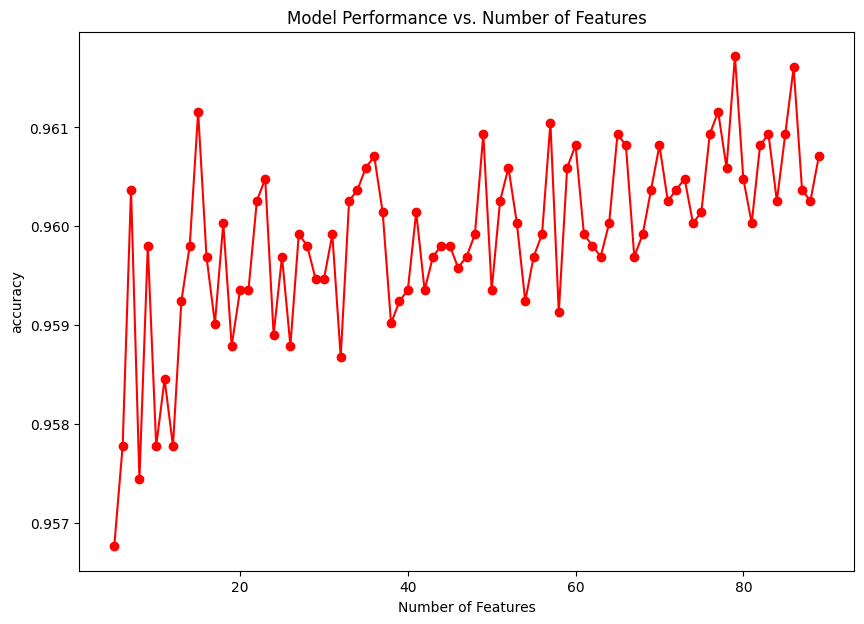

In [28]:
# Optimal no. of features

ml.plot_num_feature_performance(xg_boost_test,  X, y, final_features, scoring='accuracy', val=True)

Finding optimal no. of features..: 100%|████████| 85/85 [02:33<00:00,  1.81s/it]


Maximum f1 = 0.1489 for 15 features


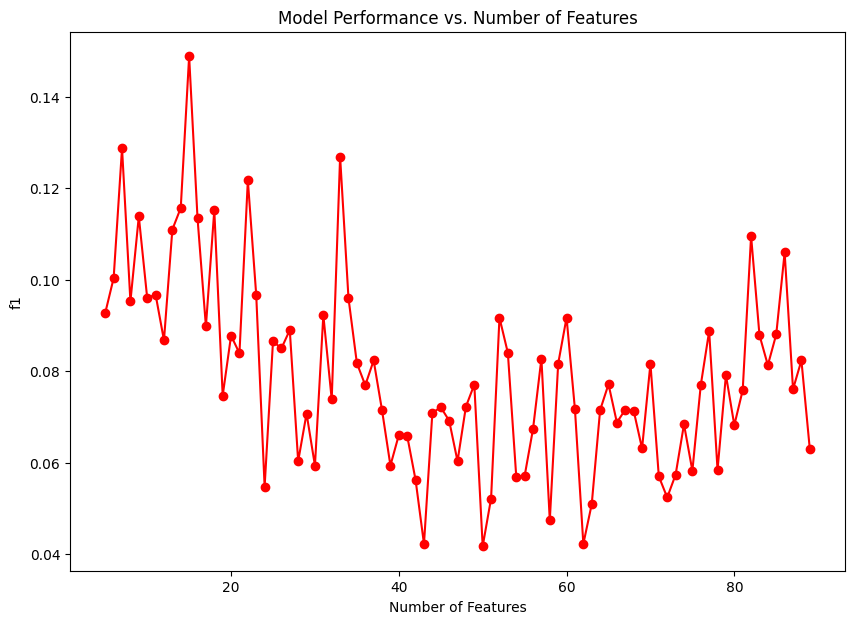

In [29]:
# Optimal no. of features

ml.plot_num_feature_performance(xg_boost_test,  X, y, final_features, scoring='f1', val=True)

Finding optimal no. of features..: 100%|████████| 85/85 [02:29<00:00,  1.76s/it]


Maximum recall = 0.0914 for 15 features


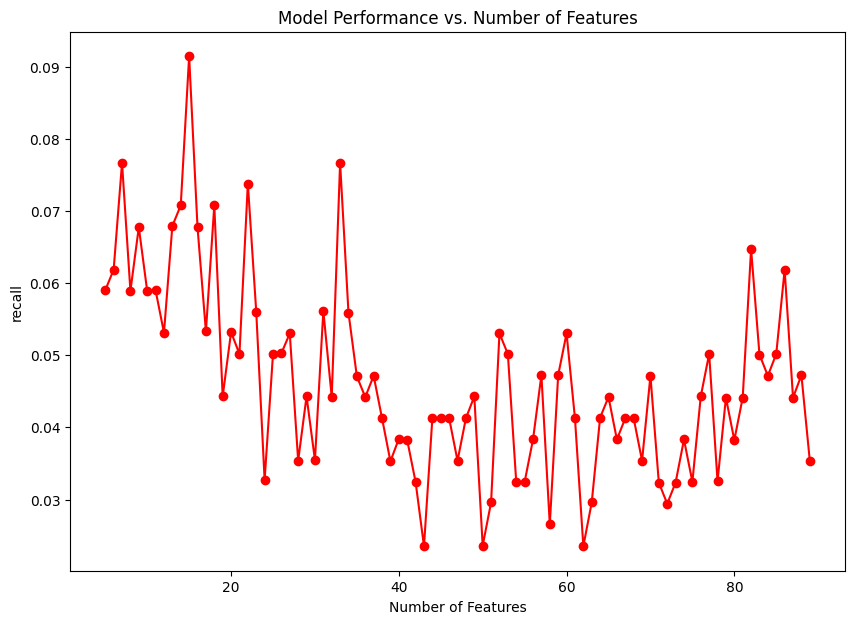

In [30]:
# Optimal no. of features

ml.plot_num_feature_performance(xg_boost_test,  X, y, final_features, scoring='recall', val=True)

In [31]:
num_features = 15

selected = final_features[:num_features]
selected.append('Anemia')

anemia_df = anemia_df[selected]

In [32]:
# Save feature set
    
with open('../Models/Anemia/Feature Sets/XG Boost Features.pkl', 'wb') as f:
    ml.pickle.dump(selected, f)

## Preprocessing

### Zero Imputation

In [33]:
# Imputing null values with zeroes

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = anemia_df, label = 'Anemia',
                                                        impute = True, scale=True,
                                                        imputer=ml.SimpleImputer(strategy='constant',fill_value=0),
                                                        random_state=42)

In [34]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.934

F1-Score: 0.966


### Mode Imputation

In [35]:
# Imputing with most frequent values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = anemia_df, label = 'Anemia',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='most_frequent'),
                                                              random_state=42)

In [36]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.919

F1-Score: 0.958


### Multiple Imputation by Chained Equations (MICE)

In [37]:
# Imputes by looking at data from other columns and trying to estimate the best prediction for each missing value.

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = anemia_df, label = 'Anemia',
                                                              impute = True, scale=True,
                                                              imputer=ml.IterativeImputer(max_iter=20),
                                                              random_state=42)

In [38]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.997

Test Accuracy: 0.998

Precision: 1.000

Recall: 0.941

F1-Score: 0.970


### Median Imputation

In [39]:
# Imputing with median values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = anemia_df, label = 'Anemia',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='median'),
                                                              random_state=42)

In [40]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.919

F1-Score: 0.958


### Mean Imputation

In [41]:
# Splitting and Preprocessing data

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = anemia_df, label = 'Anemia',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [42]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.996

Test Accuracy: 0.997

Precision: 1.000

Recall: 0.919

F1-Score: 0.958


### k-NN Imputation

In [43]:
# Imputing missing values with values from the k-nearest neighbors in the feature space

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = anemia_df, label = 'Anemia',
                                                              impute = True, scale=True,
                                                              imputer=ml.KNNImputer(n_neighbors=20),
                                                              random_state=42)

In [44]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 0.998

Test Accuracy: 0.998

Precision: 1.000

Recall: 0.956

F1-Score: 0.977


### Dropping Null Values

In [45]:
# Drop null values
anemia_df_na = anemia_df.dropna()

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = anemia_df_na, label = 'Anemia',
                                                              impute = False, scale=True,
                                                              random_state=42)

In [46]:
xg_boost.fit(X_train.values, y_train.values)

ml.evaluate_model_metrics(xg_boost,X_train,y_train,X_val,y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


## Oversampling and Undersampling

### Random Oversampling

In [47]:
X_ros, y_ros = ml.random_over_sample(X_train, y_train)

xg_boost.fit(X_ros.values, y_ros.values)

ml.evaluate_model_metrics(xg_boost,X_ros, y_ros,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### SMOTE (Synthetic Minority Over-sampling Technique)

In [48]:
X_smote, y_smote = ml.smote_over_sample(X_train, y_train)

xg_boost.fit(X_smote.values, y_smote.values)

ml.evaluate_model_metrics(xg_boost,X_smote, y_smote,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 0.989

F1-Score: 0.994


### Random Undersampling

In [49]:
X_rus, y_rus = ml.random_under_sample(X_train, y_train)

xg_boost.fit(X_rus.values, y_rus.values)

ml.evaluate_model_metrics(xg_boost,X_rus, y_rus,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 0.693

Precision: 0.112

Recall: 1.000

F1-Score: 0.201


### Tomek Links

In [50]:
X_tomek, y_tomek = ml.tomek_links(X_train, y_train)

xg_boost.fit(X_tomek.values, y_tomek.values)

ml.evaluate_model_metrics(xg_boost,X_tomek, y_tomek,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### SMOTE + Tomek Links

In [51]:
X_smote_tomek, y_smote_tomek = ml.smote_tomek(X_train, y_train)

xg_boost.fit(X_smote_tomek.values, y_smote_tomek.values)

ml.evaluate_model_metrics(xg_boost,X_smote_tomek, y_smote_tomek,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 0.989

Recall: 1.000

F1-Score: 0.994


In [52]:
# Model seems to perform better without oversampling or undersampling

## Hyperparameter Optimization 

In [53]:
param_grid = {
    
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 1.5, 2, 3],
    
}

### Random Search

In [54]:
rand_best_params, xg_boost_rand = ml.random_search_optimize(xg_boost,param_grid,n_iter=100,cv=5,
                                                               X_train=X_train, y_train=y_train,
                                                               scoring='accuracy', val=True)

In [55]:
rand_best_params

{'subsample': 0.8,
 'reg_lambda': 1.5,
 'reg_alpha': 0.3,
 'learning_rate': 0.01,
 'gamma': 0.2}

In [56]:
ml.evaluate_model_metrics(xg_boost_rand,X_train,y_train,X_val,y_val)


Train Accuracy: 0.957

Test Accuracy: 0.961

Precision: 0.000

Recall: 0.000

F1-Score: 0.000


### Optuna

In [58]:
def objective(trial):

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    }

    if params['booster'] == 'gbtree' or params['booster'] == 'dart':
        params['subsample'] = trial.suggest_uniform('subsample', 0.1, 1.0)
        params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)

    model = ml.XGBClassifier(**params)
    
    model.fit(X_train.values, y_train.values)
    y_pred = model.predict(X_test.values)

    accuracy = ml.accuracy_score(y_test.values, y_pred)

    return accuracy

In [59]:
best_trial , xg_boost_opt = ml.optuna_optimize(objective, ml.XGBClassifier, n_trials=150)

In [60]:
best_trial

{'booster': 'gbtree',
 'lambda': 2.1086411583506237e-08,
 'alpha': 1.302658754987705e-08,
 'max_depth': 6,
 'eta': 0.3411802902435157,
 'gamma': 8.127970328098618e-08,
 'grow_policy': 'depthwise',
 'subsample': 0.915077442180979,
 'colsample_bytree': 0.8170804059621608}

In [61]:
xg_boost_opt.fit(X_train.values,y_train.values)

ml.evaluate_model_metrics(xg_boost_opt,X_train,y_train,X_val,y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


## Evaluation on Test Set


Train Accuracy: 0.994

Test Accuracy: 0.993

Precision: 0.952

Recall: 0.909

F1-Score: 0.930

Confusion Matrix:

[[2190    5]
 [  10  100]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      2195
     Class 1       0.95      0.91      0.93       110

    accuracy                           0.99      2305
   macro avg       0.97      0.95      0.96      2305
weighted avg       0.99      0.99      0.99      2305


ROC-AUC Curve:


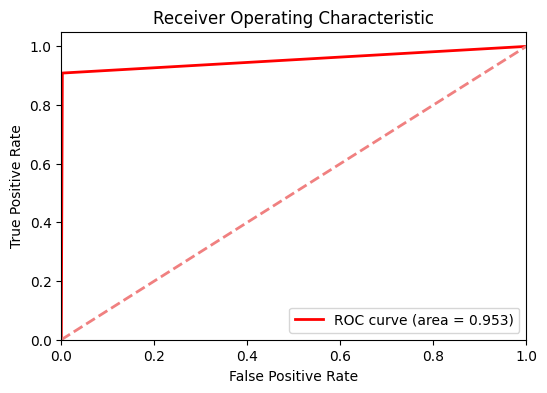

In [68]:
# After evaluating on the validation set, we evaluate and finalize on the test set

ml.evaluate_model_metrics(xg_boost_opt, X_train, y_train, X_test, y_test, verbose=6)

## Cross Validation

### K-fold

In [62]:
ml.k_cross_validate(xg_boost,X.values,y.values,cv=10,scoring='accuracy')


accuracy scores: [0.95493934 0.94800693 0.953125   0.95833333 0.94444444 0.94965278
 0.953125   0.953125   0.95486111 0.953125  ]

Mean accuracy score:  0.9522737940496823

Standard deviation:  0.0037388517592257062


In [63]:
ml.k_cross_validate(xg_boost_rand,X.values,y,cv=10,scoring='accuracy')


accuracy scores: [0.95320624 0.95320624 0.95486111 0.95486111 0.95486111 0.95486111
 0.95486111 0.95486111 0.95486111 0.95486111]

Mean accuracy score:  0.9545301367225111

Standard deviation:  0.0006619487772001164


In [64]:
ml.k_cross_validate(xg_boost_opt,X.values,y,cv=10,scoring='accuracy')


accuracy scores: [0.95147314 0.94280763 0.95486111 0.96006944 0.94444444 0.94791667
 0.953125   0.94965278 0.94791667 0.94444444]

Mean accuracy score:  0.9496711318120546

Standard deviation:  0.005080729178524827


### Stratified K-fold

In [65]:
ml.stratified_k_cross_validate(xg_boost,X,y,n_splits=10)


Average Accuracy: 0.9521007847101869

Average Precision: 0.3730555555555556

Average Recall: 0.08404558404558404

Average F1-Score: 0.1355658757587371


In [66]:
ml.stratified_k_cross_validate(xg_boost_rand,X,y,n_splits=10)


Average Accuracy: 0.9545301367225111

Average Precision: 0.0

Average Recall: 0.0

Average F1-Score: 0.0


In [67]:
ml.stratified_k_cross_validate(xg_boost_opt,X,y,n_splits=10)


Average Accuracy: 0.9498426367225109

Average Precision: 0.3272222222222222

Average Recall: 0.0876068376068376

Average F1-Score: 0.1359258596195449


### Save Model

In [69]:
final_xgb_estimator = xg_boost_opt

In [70]:
# Saving the model

ml.save_model(final_xgb_estimator, "../Models/Anemia/XGBoost_Classifier.pkl")

Saved Model


## Prediction

In [71]:
# Predicting on perturbed values

ml.predict_on_modified_instance(final_xgb_estimator, X_test.iloc[0], y_test.iloc[0], 0.6)

Instance:
 [ 0.         -0.07326498 -0.56139948 -0.45379228 -0.54596491  0.86596925
 -0.35334547 -0.69101133 -0.87716812  0.68879486  0.39849975 -0.40605758
 -0.54610064 -0.50498319 -0.52535698]

Expected Class:  0

 Modified Instance:
 [ 0.         -0.05626526 -1.08862319 -0.59591127 -0.68656858  0.91326352
 -0.39185866 -0.54732015 -0.7784912   0.82907893  0.48864625 -0.29799898
 -0.56513637 -0.51884499 -0.49456526]

Predicted Class:  [0]


In [75]:
ml.predict_on_modified_instance(final_xgb_estimator, X_test.iloc[8], y_test.iloc[8], 1.5)

Instance:
 [ 0.         -1.07882995 -0.62687904 -0.84240326 -1.75746765  1.96540601
 -1.89431843 -1.09613498 -1.16144385  0.54320631  0.68063886 -0.7845399
  1.6224718   0.50491015  0.92647796]

Expected Class:  1

 Modified Instance:
 [ 0.         -1.04157295 -0.59933143 -0.86941699 -1.57902688  2.12362013
 -1.8954795  -0.98006089 -1.02786778  0.29009491  0.91422183 -0.86912495
  1.80041619  0.43614673  0.88692153]

Predicted Class:  [0]


In [90]:
ml.predict_on_modified_instance(final_xgb_estimator, X_test.iloc[88], y_test.iloc[88], 1.5)

Instance:
 [ 0.          1.65056068 -1.9364702  -1.93537165  1.27637955 -1.54179725
 -0.89799971  1.60398637 -1.99396563  0.25202919 -0.04486172  0.50229999
 -1.30807018 -0.58914097 -1.39645794]

Expected Class:  1

 Modified Instance:
 [ 0.          1.5617376  -2.1291582  -1.86714303  1.69778295 -1.52108637
 -0.78012884  1.96519074 -2.08476633  0.33357917 -0.05356158  0.37799225
 -1.33695097 -0.51878541 -1.29419997]

Predicted Class:  [1]


In [78]:
y_test[y_test==1]

2798    1
6465    1
1267    1
8047    1
2870    1
       ..
6332    1
4031    1
8291    1
6602    1
2960    1
Name: Anemia, Length: 110, dtype: int64